In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import sem
import seaborn as sns
import matplotlib.pyplot as plt

## Required physio pre-processing steps before running this analysis script:

1. Download the DICOM files for the MID participant
2. Copy the necessary Physio DICOM files to the correct DICOM preprocessing folder
    cd to /restricted/projectnb/cd-lab/yesh/physio/MID so that you are inside the MID directory:
   * run sh copy_physio_logs.sh ppt id [i.e. sh copy_physio_logs.sh 4115]

3. Run the MATLAB preprocessing script to extract the peak times column file, which is the necessary input for this script. 2 ways to run this.
    cd to /restricted/projectnb/cd-lab/yesh/physio/MID so that you are inside the MID directory:
    * then you can use module load matlab > matlab> process_physio(participant id) [i.e. process_physio(4115)]
4. Upload data csv file to /restricted/projectnb/cd-lab/yesh/physio/MID/CSVs


## Loading physiological and CSV data

In [2]:
participants = ["4111", "4112", "4113", "4114", "4115", "4117", "4120", "4125", "4127", "4121", "4142", "4139", "4148", "4145", "4152", "4149", "4103",
               "4156", "4160", "4157", "4159"]  

In [59]:
base_path="/restricted/projectnb/cd-lab/yesh/physio/MID"
participant_path = f"{base_path}/Physio_outputs/p{participants}"
peak_base=participant_path
base_dir = "/restricted/projectnb/cd-lab/yesh/physio/MID/DICOMS"
csv_base = "/restricted/projectnb/cd-lab/yesh/physio/MID/CSVs"

In [3]:
def load_data(csv_path):
    data = pd.read_csv(csv_path)
    cleaned = data[data["EarlyHit"] == 0].reset_index(drop=True)
    return cleaned

In [4]:
def load_peak_times(base_path, n_runs=4):
    peak_times = []
    for run in range(1, n_runs + 1):
        file_path = os.path.join(base_path, f"peakTimes_PPG_Siemens_col_r{run}.txt")
        print(f"Loading: {file_path}")  # Debug print
        peak_times.append(np.loadtxt(file_path))
    return peak_times


In [5]:
def extract_cue_times(data_csv, n_runs=4):
    cue_times = []
    for run in range(1, n_runs + 1):
        run_cues = data_csv.loc[data_csv["RunNumber"] == run, "TrialOnset"].values
        cue_times.append(run_cues)
    return cue_times


In [6]:
def extract_event_aligned_ibi(peak_times, cue_times, bin_centers):
    ibi_values = np.diff(peak_times)
    ibi_times = peak_times[:-1]
    n_bins = len(bin_centers)
    
    all_trials_ibi = []
    for cue in cue_times:
        bin_times = cue + bin_centers
        trial_ibi = np.full(n_bins, np.nan)
        for i, t in enumerate(bin_times):
            idx = np.searchsorted(ibi_times, t, side='right') - 1
            if 0 <= idx < len(ibi_values):
                trial_ibi[i] = ibi_values[idx]
        all_trials_ibi.append(trial_ibi)
    return np.array(all_trials_ibi) 
    #returns an IBI matrix for EACH run 
    


In [7]:
def plot_trials(ibi_matrix, bin_centers, run_number, n_to_plot=5):
    plt.figure(figsize=(10, 5))
    for i in range(n_to_plot):
        plt.plot(bin_centers, ibi_matrix[i], label=f'Trial {i+1}')
    plt.axvline(0, color='red', linestyle='--', label='Cue Onset')
    plt.xlabel("Time (s) from cue onset")
    plt.ylabel("IBI (s)")
    plt.title(f"IBI around Cue Onset (Run {run_number}, First {n_to_plot} Trials)")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Code blocks for grouping and plotting different trial types

In [8]:
def annotate_event_timeline():

    # Cue onset and offset
    plt.axvspan(0, 2, color="yellow", alpha=0.2, label="Cue Presentation")
    #plt.axvline(0, color="red", linestyle="--", label="Cue Onset")
    #plt.axvline(2, color="red", linestyle="--", label="Cue Offset")

    # Pre-target fixation (2–7s)
    plt.axvline(2.1, color="cornflowerblue", linestyle="--", label="Pre-Target Fixation Range")
    plt.axvline(7, color="cornflowerblue", linestyle="--", label="Pre-Target Fixation Range")

    # Target window (just before 7s)
    plt.axvspan(3, 7, color="plum", alpha=0.2, label="Target Onset Range")

    # Feedback onset (8s)
    #plt.axvspan(4, 8, color="purple", alpha=0.2, label="Feedback Window")


In [9]:
def plot_average_ibi_across_runs(all_runs, bin_centers):

    colors = ["blue", "green", "orange", "purple"]
    labels = [f"Run {i+1}" for i in range(len(all_runs))]

    plt.figure(figsize=(10, 5))

    for i, run_data in enumerate(all_runs):
       
        mean_ibi = np.nanmean(run_data, axis=0)

        plt.plot(bin_centers, mean_ibi, label=labels[i], color=colors[i % len(colors)])

    annotate_event_timeline()

    #plt.ylim(1.2, 1.36)
    plt.xlabel("Time (s) relative to cue")
    plt.ylabel("IBI (s)")
    plt.title("Average IBI Across Runs\nCue: 0–2s, Fixation: 2–7s, Target: at 7s, Feedback: at 8s")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [10]:
def plot_ibi_average(all_ibi_task, bin_centers):
    plt.figure(figsize=(10,5))
    mean_ibi_task=np.nanmean(all_ibi_task, axis=0)

    plt.plot(bin_centers,mean_ibi_task,label="Mean IBI", color="gray")
    annotate_event_timeline()

    #plt.ylim(1.2, 1.36)
    plt.xlabel("Time (s) relative to cue")
    plt.ylabel("IBI (s)")
    plt.title("Average IBI Across Task\nCue: 0–2s, Fixation: 2–7s, Target: at 7s, Feedback: at 8s")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [11]:
def gainorloss(cleaned, all_ibi_task):
    loss_range=(1,5)
    gain_range=(6,10)

    #grab the indices of the gain and loss trials from the data csv 
    potential_loss=cleaned[cleaned['CueType'].between(loss_range[0],loss_range[1])]
    potential_gain=cleaned[cleaned['CueType'].between(gain_range[0],gain_range[1])]

    #convert the index into an integer
    loss_indices = potential_loss.index.to_numpy()
    gain_indices = potential_gain.index.to_numpy()
    
    #Index out the loss and gain trials
    loss_trials=all_ibi_task[loss_indices]
    gain_trials=all_ibi_task[gain_indices]

    #Compute the mean for each group
    mean_ibi_loss = np.nanmean(loss_trials, axis=0)
    mean_ibi_gain = np.nanmean(gain_trials, axis=0)

    return mean_ibi_loss, mean_ibi_gain, loss_trials, gain_trials


In [12]:
def plot_gain_loss(mean_ibi_loss,mean_ibi_gain,bin_centers):
    plt.figure(figsize=(10,5))
    plt.plot(bin_centers, mean_ibi_loss, label="Potential Loss", color="red")
    plt.plot(bin_centers, mean_ibi_gain, label="Potential Gain", color="green")

    annotate_event_timeline()


    #Labels and formatting 
    plt.xlabel("Time (s) relative to cue")
    plt.ylabel("IBI (s)")
    plt.title("Average IBI around Cue Presentation Across Runs (Potential Loss vs Potential Gain)")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [13]:
def smallorlarge(cleaned, all_ibi_task):
   
    #grab the indices of the small and large trials from the data csv 
    large_cue=cleaned[cleaned['CueType'].isin([4,5,9, 10])]
    small_cue=cleaned[cleaned['CueType'].isin([1,2,6,7])]

    #convert the index into an integer
    large_indices = large_cue.index.to_numpy()
    small_indices = small_cue.index.to_numpy()
    
    #Index out the small and large trials
    large_trials=all_ibi_task[large_indices]
    small_trials=all_ibi_task[small_indices]

    #Compute the mean for each group
    mean_ibi_large = np.nanmean(large_trials, axis=0)
    mean_ibi_small = np.nanmean(small_trials, axis=0)

    return mean_ibi_large,mean_ibi_small, large_trials, small_trials


In [14]:
def plot_small_large(mean_ibi_large,mean_ibi_small,bin_centers):
    plt.figure(figsize=(10,5))
    plt.plot(bin_centers, mean_ibi_large, label="Large Cue", color="blue")
    plt.plot(bin_centers, mean_ibi_small, label="Small Cue", color="lightblue")


    annotate_event_timeline()


    #Labels and formatting 
    plt.xlabel("Time (s) relative to cue")
    plt.ylabel("IBI (s)")
    plt.title("Average IBI around Cue Presentation Across All Runs (Large vs Small Cue)")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [15]:
def assign_magnitude(cleaned, all_ibi_task):
    #grabbing the indicides of each magnitude level
    mag1=cleaned[cleaned['CueType'].isin([1, 6])]
    mag3=cleaned[cleaned['CueType'].isin([2, 7])]
    mag5=cleaned[cleaned['CueType'].isin([3, 8])]
    mag7=cleaned[cleaned['CueType'].isin([4, 9])]
    mag9=cleaned[cleaned['CueType'].isin([5, 10])]

    #converting the indices into an integer
    mag1_indices=mag1.index.to_numpy()
    mag3_indices=mag3.index.to_numpy()
    mag5_indices=mag5.index.to_numpy()
    mag7_indices=mag7.index.to_numpy()
    mag9_indices=mag9.index.to_numpy()

    #index out all the small and large trials 
    mag1_trials=all_ibi_task[mag1_indices]
    mag3_trials=all_ibi_task[mag3_indices]
    mag5_trials=all_ibi_task[mag5_indices]
    mag7_trials=all_ibi_task[mag7_indices]
    mag9_trials=all_ibi_task[mag9_indices]

    
    mean_ibi_mag1=np.nanmean(mag1_trials, axis=0)
    mean_ibi_mag3=np.nanmean(mag3_trials, axis=0)
    mean_ibi_mag5=np.nanmean(mag5_trials, axis=0)
    mean_ibi_mag7=np.nanmean(mag7_trials, axis=0)
    mean_ibi_mag9=np.nanmean(mag9_trials, axis=0)


    return mean_ibi_mag1,mean_ibi_mag3,mean_ibi_mag5,mean_ibi_mag7,mean_ibi_mag9
    

In [16]:
def plot_magnitudes(mean_ibi_mag1, mean_ibi_mag3, mean_ibi_mag5, mean_ibi_mag7, mean_ibi_mag9, bin_centers):
    plt.figure(figsize=(10,5))
    plt.plot(bin_centers, mean_ibi_mag1, label="+/- $1", color="red")
    plt.plot(bin_centers, mean_ibi_mag3, label="+/- $3", color="orange")
    plt.plot(bin_centers, mean_ibi_mag5, label="+/- $5", color="green")
    plt.plot(bin_centers, mean_ibi_mag7, label="+/- $7", color="blue")
    plt.plot(bin_centers, mean_ibi_mag9, label="+/- $9", color="hotpink")

    annotate_event_timeline()

     #Labels and formatting 
    plt.xlabel("Time (s) relative to cue")
    plt.ylabel("IBI (s)")
    plt.title("Average IBI around Cue Presentation Across Runs (Per Cue Magnitude)")
    plt.legend()
    plt.tight_layout()
    plt.show()    


## Pipeline to plot the following trials for an individual participant:
* individual trial timecoures of n trials
* average IBI timecourse plotted separately for each of the 4 runs
* average IBI timecourse across all trials in the task (aligned to cue presentation)
* average IBI timecourse across task for cues that indicate the opportunity to win money vs the opportunity to lose money
* average IBI timecourse across task for small cues (opportunity to win/lose 1 dollar or 3 dollars) vs large cues (opportunity to win/lose 5 dollars or 7 dollars)
* average IBI timecourse across task for the parametric magnitudes all plotted individually (+/- 1 dollar, 3 dollars, 5 dollars, 7 dollars, 9 dollars)

In [17]:
def run_pipeline_single(csv_path, peak_times_dir, plot_run=None, plot_n_trials=5, plot_group_average=True, plot_task_average=True, plot_gainloss=True, plot_smalllarge=True, plot_magnitudes_flag=True):
    bin_edges = np.arange(-5.0, 10.0 + 0.1, 0.1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    data = load_data(csv_path)
    peak_times_all = load_peak_times(peak_times_dir)
    cue_times_all = extract_cue_times(data)

    #creates a list of arrays, where each array corresponds to one run
    all_ibi_runs = []
    for r in range(len(peak_times_all)):
        #returns one run's IBI matrix per run 
        run_ibi = extract_event_aligned_ibi(peak_times_all[r], cue_times_all[r], bin_centers)
        all_ibi_runs.append(run_ibi)
    #creates a single 2d array combining all runs' trials vertically (the shape is [total trials across all runs, n_bins]
    
    all_ibi_task=np.vstack(all_ibi_runs)

    if plot_run is not None:
        plot_trials(all_ibi_runs[plot_run - 1], bin_centers, plot_run, n_to_plot=plot_n_trials)

    if plot_group_average:
        plot_average_ibi_across_runs(all_ibi_runs, bin_centers)

    if plot_task_average:
        plot_ibi_average(all_ibi_task, bin_centers)

    if plot_gainloss:
        mean_ibi_loss, mean_ibi_gain, loss_trials,gain_trials = gainorloss(data, all_ibi_task)
        plot_gain_loss(mean_ibi_loss,mean_ibi_gain,bin_centers)

    if plot_smalllarge:
        mean_ibi_large,mean_ibi_small, large_trials, small_trials = smallorlarge(data,all_ibi_task)
        plot_small_large(mean_ibi_large,mean_ibi_small,bin_centers)

    if plot_magnitudes_flag:
        mean_ibi_mag1, mean_ibi_mag3, mean_ibi_mag5, mean_ibi_mag7, mean_ibi_mag9 = assign_magnitude(data, all_ibi_task)
        plot_magnitudes(mean_ibi_mag1, mean_ibi_mag3, mean_ibi_mag5, mean_ibi_mag7, mean_ibi_mag9, bin_centers)


    return all_ibi_runs, bin_centers

## Example of running the pipeline for individual participant

Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4142/peakTimes_PPG_Siemens_col_r1.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4142/peakTimes_PPG_Siemens_col_r2.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4142/peakTimes_PPG_Siemens_col_r3.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4142/peakTimes_PPG_Siemens_col_r4.txt


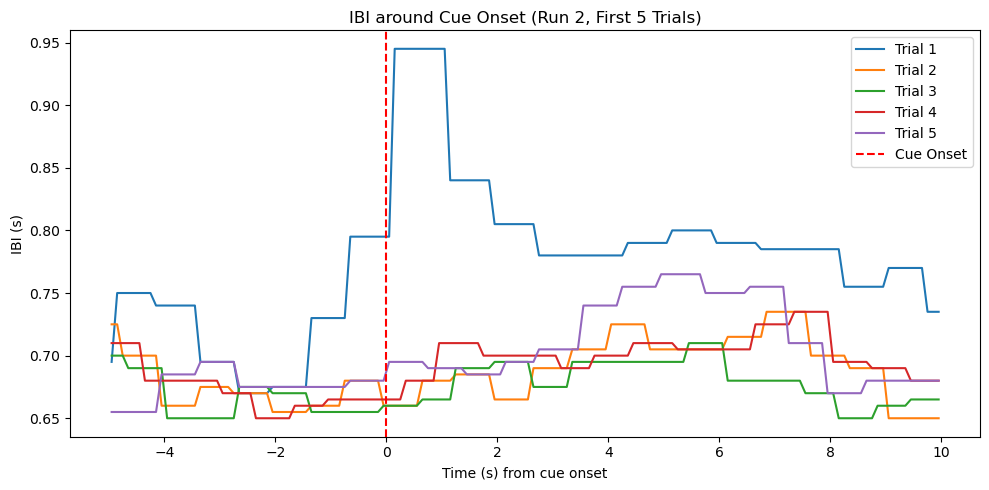

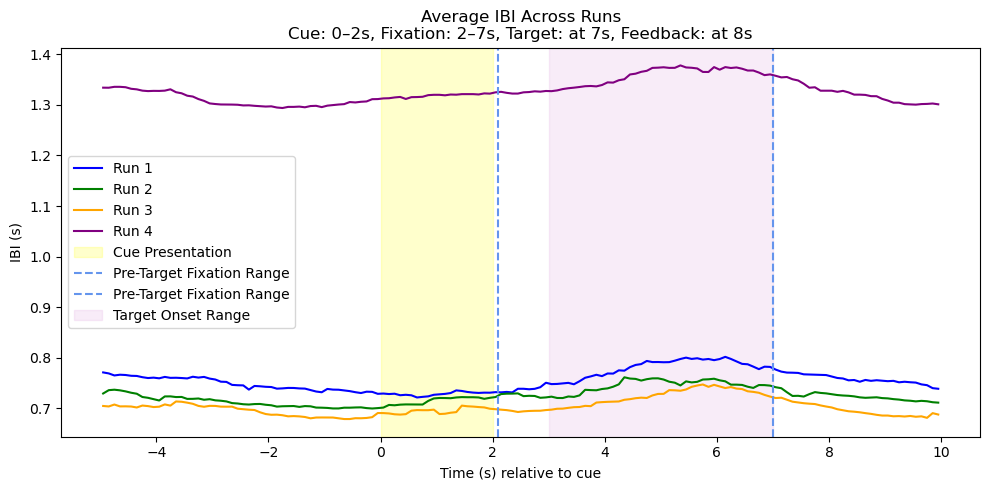

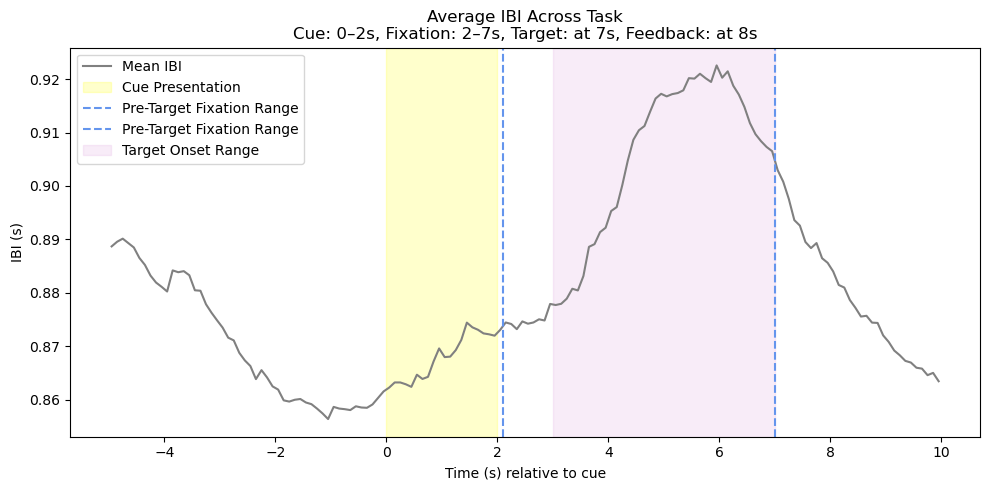

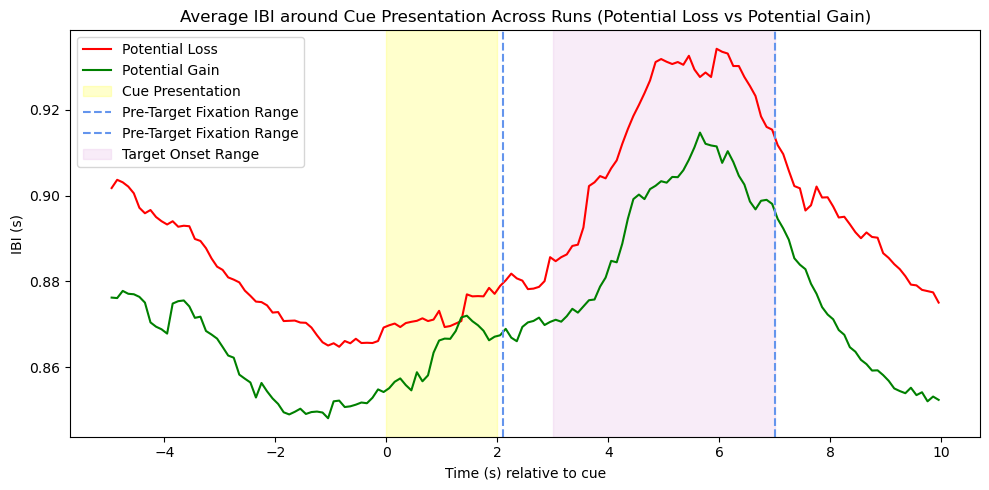

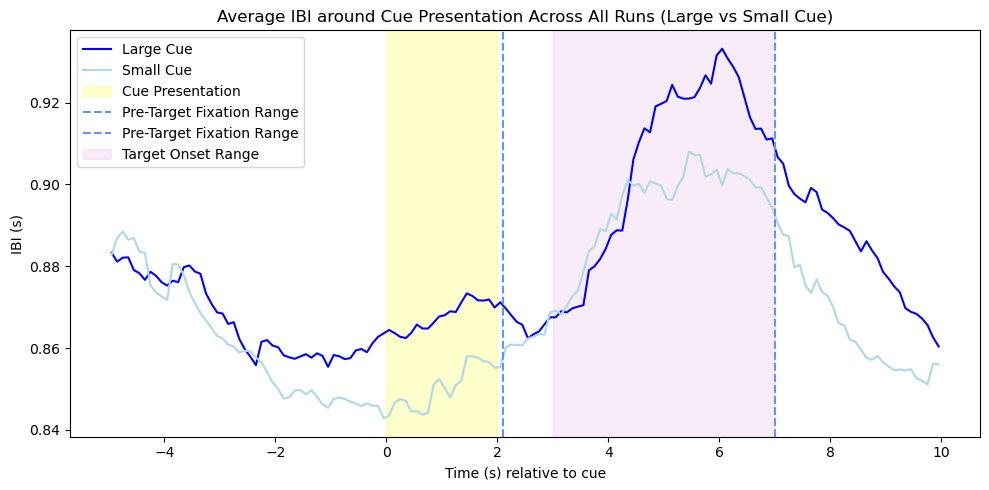

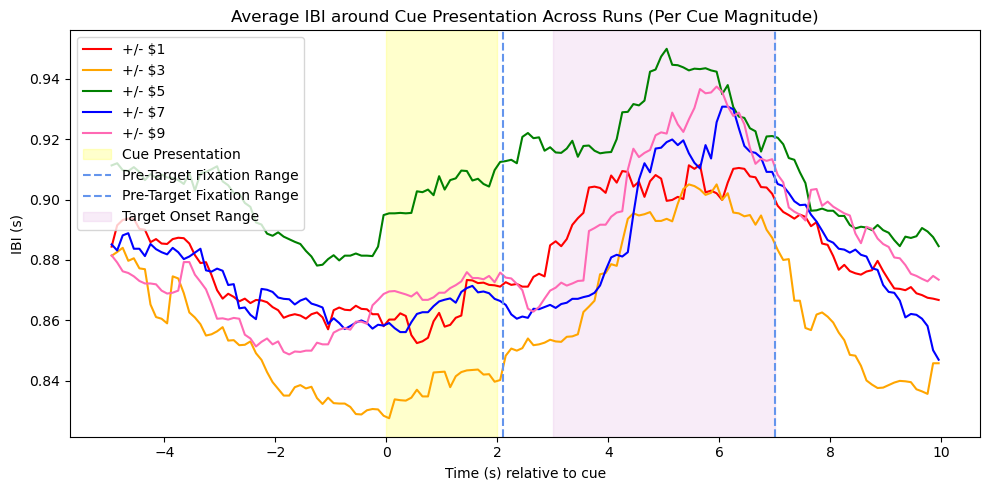

In [18]:
ppt="4142"

#Construct paths 
base_path="/restricted/projectnb/cd-lab/yesh/physio/MID"
participant_path = f"{base_path}/Physio_outputs/p{ppt}"
csv_file=f"{base_path}/CSVs/p{ppt}_data.csv"
peak_dir=participant_path

ibi_data, bins = run_pipeline_single(csv_file, peak_dir, plot_run=2)


### Incorporating participant-specific baselines for the group analyses
In order to more meaninfully compare IBI timecourses across participants, participants' IBI time coureses were expressed as %change from their baseline IBI across the entire task

In [19]:
def normalize_ibi_percent_change(all_participant_ibi):
    normalized_all= []
    for ibi_data in all_participant_ibi:
        #calculates the overall mean IBI per participant
        participant_mean=np.nanmean(ibi_data)

        #compute mean across trials at each bin
        mean_ibi=np.nanmean(ibi_data, axis=0)

        #percent change relative to overall mean
        percent_change = ((mean_ibi - participant_mean) / participant_mean) * 100

        normalized_all.append(percent_change)
    
    return normalized_all

        

## Plotting Code for Group-Level Analyses

In [21]:
#originally named plot_avg_runs_across_participants

def is_consistent_across_runs(all_ibi_runs_by_participant, bin_centers, participant_means, participants):
    """
    Plot the average normalized IBI timecourse for each run, averaged across all participants.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    n_runs = len(all_ibi_runs_by_participant[0])  # assuming each participant has same number of runs
    colors = ['blue', 'orange', 'green', 'purple']  # one color per run

    # Collect normalized runs for each run index
    runs_norm_all_participants = [[] for _ in range(n_runs)]

    for i, participant_runs in enumerate(all_ibi_runs_by_participant):
        baseline = participant_means[participants[i]]
        for run_idx in range(n_runs):
            run = participant_runs[run_idx]
            run_avg = np.nanmean(run, axis=0)
            run_norm = ((run_avg - baseline) / baseline) * 100
            runs_norm_all_participants[run_idx].append(run_norm)

    # Compute mean across participants for each run
    mean_runs = [np.nanmean(runs_norm_all_participants[run_idx], axis=0) for run_idx in range(n_runs)]

    plt.figure(figsize=(10,5))
    for run_idx in range(n_runs):
        plt.plot(bin_centers, mean_runs[run_idx], color=colors[run_idx % len(colors)], label=f'Run {run_idx+1}')

    # Legend
    legend_elements = [
        Line2D([0], [0], color=colors[i], lw=2, label=f'Run {i+1}')
        for i in range(n_runs)
    ]

    annotate_event_timeline()
    plt.title('Average Normalized IBI Timecourse per Run Across Participants')
    plt.xlabel("Time (s) relative to cue")
    plt.ylabel("IBI (% change from person-specific mean)")
    plt.legend(handles=legend_elements)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("ibi_across_runs_cue.png", dpi=300, bbox_inches='tight')

    plt.show()


In [1]:
#previously named plot_average_ibi_all_participants_with_group_avg
def what_shape_cue_presentation(all_participant_ibi, bin_centers, participants):
    # Normalize individual participants' IBI as percent change
    normalized_all = normalize_ibi_percent_change(all_participant_ibi)
    
    plt.figure(figsize=(10, 5))
    
    # Plot each participant's normalized IBI
    for i, percent_change in enumerate(normalized_all):
        plt.plot(bin_centers, percent_change, alpha=0.6)
    
    # Compute grand average across participants (average over all normalized timecourses)
    group_avg = np.nanmean(normalized_all, axis=0)
    
    # Plot the grand average with a thicker line and distinct color
    plt.plot(bin_centers, group_avg, color='black', lw=3, label='Group Average')
    
    annotate_event_timeline()
    plt.xlabel("Time (s) relative to cue")
    plt.ylabel("IBI (% change from person-specific mean)")
    plt.title("Normalized IBI (% Change) Across Participants (Aligned to Cue Onset)")
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # reference line at 0%
    plt.legend()
    plt.tight_layout()
    plt.savefig("group_ibi_cue.png", dpi=300, bbox_inches='tight')  # <--- Save the figure
    plt.show()


In [27]:
#previously named plot_group_gain_vs_loss
def is_difference_gain_vs_loss(mean_loss_list, mean_gain_list, bin_centers, participants):
    """
    Plots the average IBI timecourse across all participants for gain and loss trials,
    including standard error bands.
    """
    try:
       

        gain_stack = np.vstack(mean_gain_list)
        loss_stack = np.vstack(mean_loss_list)


        gain_mean = np.nanmean(gain_stack, axis=0)
        gain_se = sem(gain_stack, axis=0, nan_policy='omit')

        loss_mean = np.nanmean(loss_stack, axis=0)
        loss_se = sem(loss_stack, axis=0, nan_policy='omit')

        plt.figure(figsize=(10, 5))
        plt.plot(bin_centers, gain_mean, label='Potential Gain Trials', color='green')
        plt.fill_between(bin_centers, gain_mean - gain_se, gain_mean + gain_se, alpha=0.3, color='green')

        plt.plot(bin_centers, loss_mean, label='Potential Loss Trials', color='red')
        plt.fill_between(bin_centers, loss_mean - loss_se, loss_mean + loss_se, alpha=0.3, color='red')

        annotate_event_timeline()
        plt.xlabel("Time (s) relative to cue")
        plt.ylabel('IBI (% change from baseline)')
        plt.title(f'Group-Averaged IBI: Gain vs. Loss Trials (Aligned to Cue Onset)\n(n={len(participants)} participants)')
        plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # reference line at 0%
        plt.legend()
        plt.tight_layout()
        plt.savefig("gainvsloss_cue.png", dpi=300, bbox_inches='tight')

        plt.show()
    except Exception as e:
        print(f"Error in is_difference_gain_vs_loss: {e}")


In [29]:
#previously named plot_group_small_vs_large
def is_difference_small_vs_large(mean_large_list, mean_small_list, bin_centers, participants):
    """
    Plots the average IBI timecourse across all participants for small and large trials,
    including shaded standard error bands.
    """
    try:
        small_stack = np.vstack(mean_small_list)
        large_stack = np.vstack(mean_large_list)

        small_mean = np.nanmean(small_stack, axis=0)
        small_se = sem(small_stack, axis=0, nan_policy='omit')

        large_mean = np.nanmean(large_stack, axis=0)
        large_se = sem(large_stack, axis=0, nan_policy='omit')

        plt.figure(figsize=(10, 5))
        plt.plot(bin_centers, small_mean, label='Small Trials', color='dodgerblue')
        plt.fill_between(bin_centers, small_mean - small_se, small_mean + small_se, alpha=0.3, color='dodgerblue')

        plt.plot(bin_centers, large_mean, label='Large Trials', color='darkblue')
        plt.fill_between(bin_centers, large_mean - large_se, large_mean + large_se, alpha=0.3, color='darkblue')

        annotate_event_timeline()
        plt.xlabel("Time (s) relative to cue")
        plt.ylabel('IBI (% change from baseline)')
        plt.title(f'Group-Averaged IBI: Small vs. Large Trials (Aligned to Cue Onset)\n(n={len(participants)} participants)')
        plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # reference line at 0%
        plt.legend()
        plt.tight_layout()
        plt.savefig("smallvslarge_cue.png", dpi=300, bbox_inches='tight')  # <--- Save the figure

        plt.show()
    except Exception as e:
        print(f"Error in is_difference_small_vs_large: {e}")


In [30]:
#previously named plot_group_magnitudes
def is_difference_between_magnitudes(mean_ibi_mag1_list_norm, mean_ibi_mag3_list_norm, mean_ibi_mag5_list_norm, mean_ibi_mag7_list_norm, mean_ibi_mag9_list_norm, bin_centers, participants):
    try:
        mag1_stack=np.vstack(mean_ibi_mag1_list_norm)
        mag3_stack=np.vstack(mean_ibi_mag3_list_norm)
        mag5_stack=np.vstack(mean_ibi_mag5_list_norm)
        mag7_stack=np.vstack(mean_ibi_mag7_list_norm)
        mag9_stack=np.vstack(mean_ibi_mag9_list_norm)

        mag1_mean=np.nanmean(mag1_stack, axis=0)
        mag1_se=sem(mag1_stack, axis=0, nan_policy="omit")

        mag3_mean=np.nanmean(mag1_stack, axis=0)
        mag3_se=sem(mag3_stack, axis=0, nan_policy="omit")

        mag5_mean=np.nanmean(mag5_stack, axis=0)
        mag5_se=sem(mag5_stack, axis=0, nan_policy="omit")

        mag7_mean=np.nanmean(mag7_stack, axis=0)
        mag7_se=sem(mag7_stack, axis=0, nan_policy="omit")

        mag9_mean=np.nanmean(mag9_stack, axis=0)
        mag9_se=sem(mag9_stack, axis=0, nan_policy="omit")


        plt.figure(figsize=(10, 5))
        
        plt.plot(bin_centers, mag1_mean, label="+/- $1", color="red")
        #plt.fill_between(bin_centers, mag1_mean-mag1_se, mag1_mean+mag1_se, alpha=0.3, color="Red")

        plt.plot(bin_centers, mag3_mean, label="+/- $3", color="orange")
        #plt.fill_between(bin_centers, mag3_mean-mag3_se, mag3_mean+mag3_se, alpha=0.3, color="Orange")

        plt.plot(bin_centers, mag5_mean, label="+/- $5", color="Green")
        #plt.fill_between(bin_centers, mag5_mean-mag5_se, mag5_mean+mag5_se, alpha=0.3, color="Green")

        plt.plot(bin_centers, mag7_mean, label="+/- $7", color="blue")
        #plt.fill_between(bin_centers, mag7_mean-mag7_se, mag7_mean+mag7_se, alpha=0.3, color="Blue")

        plt.plot(bin_centers, mag9_mean, label="+/- $9", color="hotpink")
        #plt.fill_between(bin_centers, mag9_mean-mag9_se, mag9_mean+mag9_se, alpha=0.3, color="hotpink")

        annotate_event_timeline()
        plt.xlabel("Time (s) relative to cue")
        #plt.ylim(.7,1)
        plt.ylabel('IBI (% change from baseline)')
        plt.title(f'Group-Averaged IBI: Different Magnitudes (Aligned to Cue Onset) \n(n={len(participants)} participants)')
        plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # reference line at 0%
        plt.legend()
        plt.tight_layout()
        plt.savefig("5magnitudes.png", dpi=300, bbox_inches='tight')  # <--- Save the figure
        plt.show()

    except Exception as e:
        print(f"Error in is_difference_between_magnitudes: {e}")



Difference Waves

To make it easier to compare how heart rate dynamics change over time between trial types, difference curves were created by subtracting one condition’s average IBI timecourse from another (for example, large - small trials). These curves highlight when one condition is changing more quickly than the other, helping summarize how the cardiac response unfolds differently across trial types rather than just comparing overall levels.

In [31]:
def plot_group_diff_waves(diff_large_small, diff_loss_gain, bin_centers, participants):
    try:
        large_small_stack=np.vstack(diff_large_small)
        loss_gain_stack=np.vstack(diff_loss_gain)

        large_small_group=np.nanmean(large_small_stack, axis=0)
        large_small_se=sem(large_small_stack, nan_policy="omit")

        loss_gain_group=np.nanmean(loss_gain_stack, axis=0)
        loss_gain_se=sem(loss_gain_stack, nan_policy="omit")

        plt.figure(figsize=(10, 5))
        plt.plot(bin_centers, loss_gain_group, label="loss-gain difference curve", color="magenta")
        plt.fill_between(
            bin_centers,
            loss_gain_group - loss_gain_se,
            loss_gain_group + loss_gain_se,
            color="magenta", alpha=0.1
        )
        plt.plot(bin_centers, large_small_group, label="large-small difference curve", color="maroon")
        plt.fill_between(
            bin_centers,
            large_small_group - large_small_se,
            large_small_group + large_small_se,
            color="maroon", alpha=0.1
        )


        annotate_event_timeline()
        plt.xlabel("Time (s) relative to cue")
        #plt.ylim(.7,1)
        plt.ylabel('IBI (% change from baseline)')
        plt.title(f'Group-Averaged IBI: Different Waves \n(n={len(participants)} participants)')
        plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # reference line at 0%
        plt.legend()
        plt.tight_layout()
        plt.savefig("diff_waves_cue.png", dpi=300, bbox_inches='tight')  # <--- Save the figure
        plt.show()

    except Exception as e:
        print(f"Error in is_difference_between_magnitudes: {e}")


In [34]:
#previously named plot_raw_ibi_spaghetti
def is_mean_ibi_consistent_across_runs(all_peak_times_by_participant, participants):
    # --- Compute mean raw IBI per run per participant ---
    raw_ibi_records = []

    for subj_idx, runs in enumerate(all_peak_times_by_participant):
        for run_num, peaks in enumerate(runs, start=1):
            ibis = np.diff(peaks)  # seconds between consecutive peaks
            mean_ibi = np.nanmean(ibis)
            raw_ibi_records.append({
                "participant": participants[subj_idx],
                "run": run_num,
                "mean_IBI": mean_ibi
            })

    raw_ibi_df = pd.DataFrame(raw_ibi_records)

    # --- Group average per run ---
    group_avg_df = raw_ibi_df.groupby("run", as_index=False)["mean_IBI"].mean()
    group_avg_df.rename(columns={"mean_IBI": "group_mean_IBI"}, inplace=True)

    # --- Plot spaghetti + group average ---
    plt.figure(figsize=(8, 6))

    # Individual participant lines
    for pid, grp in raw_ibi_df.groupby("participant"):
        plt.plot(grp["run"], grp["mean_IBI"], marker="o", alpha=0.5)

    # Group average line
    plt.plot(group_avg_df["run"], group_avg_df["group_mean_IBI"],
             color="black", linewidth=2, marker="o", label="Group Avg")

    plt.xlabel("Run Number")
    plt.ylabel("Mean Raw IBI (s)")
    plt.title("Raw Mean IBI per Run - All Participants (Unaligned)")
    plt.xticks(sorted(raw_ibi_df["run"].unique()))
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig("raw_ibi_across_runs.png", dpi=300, bbox_inches='tight')
    plt.show()


## Group pipeline NOT condition-specific baseline version
I made a condition-specific baseline corrected version in order to better align the different groups' timecoureses (position on the y-axis) when entering the cue presentation window

In [35]:
def run_group_pipeline(participants, base_dir, plot_all=True):
    """
    Runs group level IBI analysis pipeline:
    - Loads multiple participants data and peak times
    - Calculates per-run baselines and normalized metrics 
    - Aggregates group data for plotting and group level analyses
    - Returns raw peak times for optional unaligned IBI analysis
    """
    import traceback
    import os
    import numpy as np

    # initialize storage for group results 
    all_ibi_runs_by_participant = []  # list of per-participant lists of runs (each run is a 2d array)
    all_participant_runs = []  # flattened list of all run data for all participants
    all_peak_times_by_participant = []  #raw peak timestamps for each participant
    cleaned_dict={}

    mean_loss_list = []
    mean_gain_list = []
    mean_loss_list_norm = []
    mean_gain_list_norm = []

    mean_small_list = []
    mean_large_list = []
    mean_small_list_norm = []
    mean_large_list_norm = []

    mean_mag1_list=[]
    mean_mag3_list=[]
    mean_mag5_list=[]
    mean_mag7_list=[]
    mean_mag9_list=[]

    mean_ibi_mag1_list_norm=[]
    mean_ibi_mag3_list_norm=[]
    mean_ibi_mag5_list_norm=[]
    mean_ibi_mag7_list_norm=[]
    mean_ibi_mag9_list_norm=[]
    
    
    bin_centers = None
    participant_means = {}  # store person-specific baselines

    # iterate over all participants 
    for pid in participants:
        try:
            # Define file paths 
            participant_path = f"{base_path}/Physio_outputs"
            peak_base = participant_path
            print(f"\n--- Starting {pid} ---")
            
            csv_path = os.path.join(csv_base, f"p{pid}_data.csv")
            peak_times_dir = os.path.join(peak_base, f"p{pid}")

            #print(f"CSV path: {csv_path}")
            #print(f"Peak times dir: {peak_times_dir}")
            
            # Check that csv and peak files exist 
            if not os.path.exists(csv_path):
                print(f"❌ CSV file not found for {pid}")
                continue
            if not os.path.isdir(peak_times_dir):
                print(f"❌ Peak directory not found for {pid}")
                continue
            
            # ---  load raw peak times (unaligned) ---
            peaks_for_participant = load_peak_times(peak_times_dir, n_runs=4)
            all_peak_times_by_participant.append(peaks_for_participant)
            
            # Run single participant pipeline to get aligned IBIs
            all_ibi_runs, bin_centers = run_pipeline_single(
                csv_path=csv_path,
                peak_times_dir=peak_times_dir,
                plot_run=None,
                plot_n_trials=0,
                plot_group_average=False,
                plot_task_average=False,
                plot_gainloss=False,
                plot_smalllarge=False,
                plot_magnitudes_flag=False
            )

            all_ibi_runs_by_participant.append(all_ibi_runs)

            # Stack all runs for this participant into a 2d array
            participant_ibi = np.vstack(all_ibi_runs)

            if participant_ibi.size == 0:
                print(f"No IBI data for participant {pid}")
                continue

            # Compute person-specific baseline
            participant_mean_ibi = np.nanmean(participant_ibi)
            participant_means[pid] = participant_mean_ibi

            # Load cleaned csv - early hit trials removed  
            cleaned = load_data(csv_path)
            cleaned_dict[pid]=cleaned

            ## --- Trial type averages and normalizations ----
            # Gain/Loss
            mean_ibi_loss, mean_ibi_gain, loss_trials, gain_trials = gainorloss(cleaned, participant_ibi)
            mean_loss_list.append(mean_ibi_loss)
            mean_gain_list.append(mean_ibi_gain)
            mean_ibi_loss_norm = ((mean_ibi_loss - participant_mean_ibi) / participant_mean_ibi) * 100
            mean_ibi_gain_norm = ((mean_ibi_gain - participant_mean_ibi) / participant_mean_ibi) * 100
            mean_loss_list_norm.append(mean_ibi_loss_norm)
            mean_gain_list_norm.append(mean_ibi_gain_norm)

            # Small/Large
            mean_ibi_large, mean_ibi_small, large_trials, small_trials = smallorlarge(cleaned, participant_ibi)
            mean_small_list.append(mean_ibi_small)
            mean_large_list.append(mean_ibi_large)
            mean_ibi_small_norm = ((mean_ibi_small - participant_mean_ibi) / participant_mean_ibi) * 100
            mean_ibi_large_norm = ((mean_ibi_large - participant_mean_ibi) / participant_mean_ibi) * 100
            mean_small_list_norm.append(mean_ibi_small_norm)
            mean_large_list_norm.append(mean_ibi_large_norm)
            
            #Magnitude
            mean_ibi_mag1, mean_ibi_mag3, mean_ibi_mag5, mean_ibi_mag7, mean_ibi_mag9= assign_magnitude(cleaned, participant_ibi)
            mean_mag1_list.append(mean_ibi_mag1)
            mean_mag3_list.append(mean_ibi_mag3)
            mean_mag5_list.append(mean_ibi_mag5)
            mean_mag7_list.append(mean_ibi_mag7)
            mean_mag9_list.append(mean_ibi_mag9)

            mean_ibi_mag1_norm=((mean_ibi_mag1 - participant_mean_ibi) / participant_mean_ibi) * 100
            mean_ibi_mag3_norm=((mean_ibi_mag3 - participant_mean_ibi) / participant_mean_ibi) * 100
            mean_ibi_mag5_norm=((mean_ibi_mag5 - participant_mean_ibi) / participant_mean_ibi) * 100
            mean_ibi_mag7_norm=((mean_ibi_mag7 - participant_mean_ibi) / participant_mean_ibi) * 100
            mean_ibi_mag9_norm=((mean_ibi_mag9 - participant_mean_ibi) / participant_mean_ibi) * 100

            mean_ibi_mag1_list_norm.append(mean_ibi_mag1_norm)
            mean_ibi_mag3_list_norm.append(mean_ibi_mag3_norm)
            mean_ibi_mag5_list_norm.append(mean_ibi_mag5_norm)
            mean_ibi_mag7_list_norm.append(mean_ibi_mag7_norm)
            mean_ibi_mag9_list_norm.append(mean_ibi_mag9_norm)

            all_participant_runs.append(participant_ibi)

        except Exception as e:
            print(f"Failed to process {pid}: {e}")
            traceback.print_exc()

    if not all_participant_runs:
        print("No participant data found — cannot stack arrays.")
        return None, None, None, None, None, None

    # Stack all participants' data vertically (all trials from all participants)
    group_ibi_matrix = np.vstack(all_participant_runs)

    if plot_all:
        #plot_4_runs_by_participant(all_ibi_runs_by_participant, bin_centers, participants, participant_means)
        is_consistent_across_runs(all_ibi_runs_by_participant, bin_centers, participant_means, participants)
        what_shape_cue_presentation(all_participant_runs, bin_centers, participants)
        is_difference_gain_vs_loss(mean_loss_list_norm, mean_gain_list_norm, bin_centers, participants)
        is_difference_small_vs_large(mean_large_list_norm, mean_small_list_norm, bin_centers, participants)
        is_difference_between_magnitudes(mean_ibi_mag1_list_norm, mean_ibi_mag3_list_norm, mean_ibi_mag5_list_norm, mean_ibi_mag7_list_norm, mean_ibi_mag9_list_norm, bin_centers, participants)
    # --- Now returns peak times too ---
    return (
        all_participant_runs,            # aligned and stacked
        group_ibi_matrix, 
        bin_centers, 
        participant_means, 
        all_ibi_runs_by_participant,     # aligned per run
        all_peak_times_by_participant,
        cleaned_dict
          )



--- Starting 4111 ---
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4111/peakTimes_PPG_Siemens_col_r1.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4111/peakTimes_PPG_Siemens_col_r2.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4111/peakTimes_PPG_Siemens_col_r3.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4111/peakTimes_PPG_Siemens_col_r4.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4111/peakTimes_PPG_Siemens_col_r1.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4111/peakTimes_PPG_Siemens_col_r2.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4111/peakTimes_PPG_Siemens_col_r3.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4111/peakTimes_PPG_Siemens_col_r4.txt

--- Starting 4112 ---
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4112/peakTimes_PPG_S

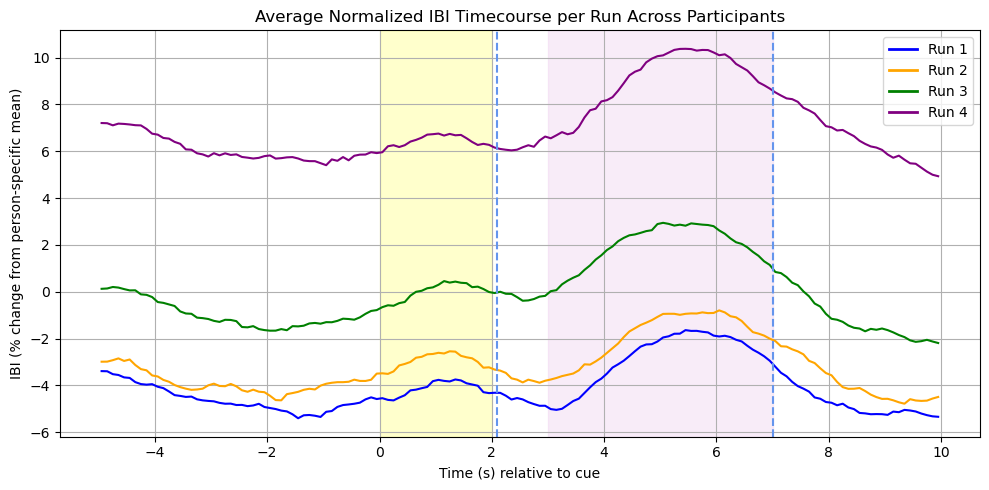

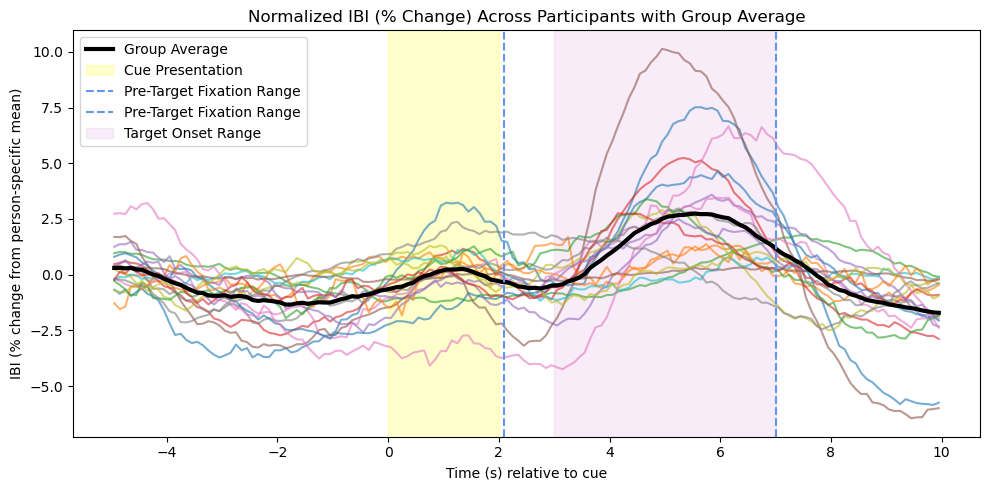

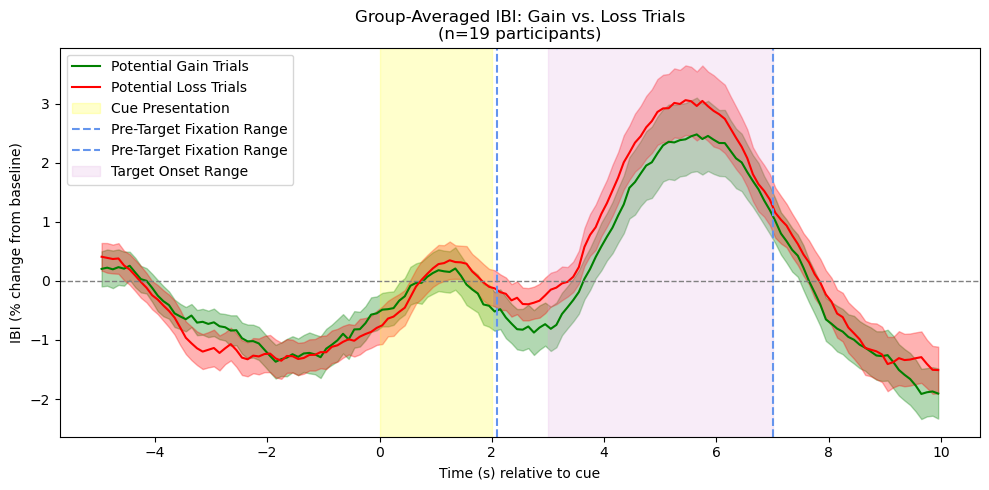

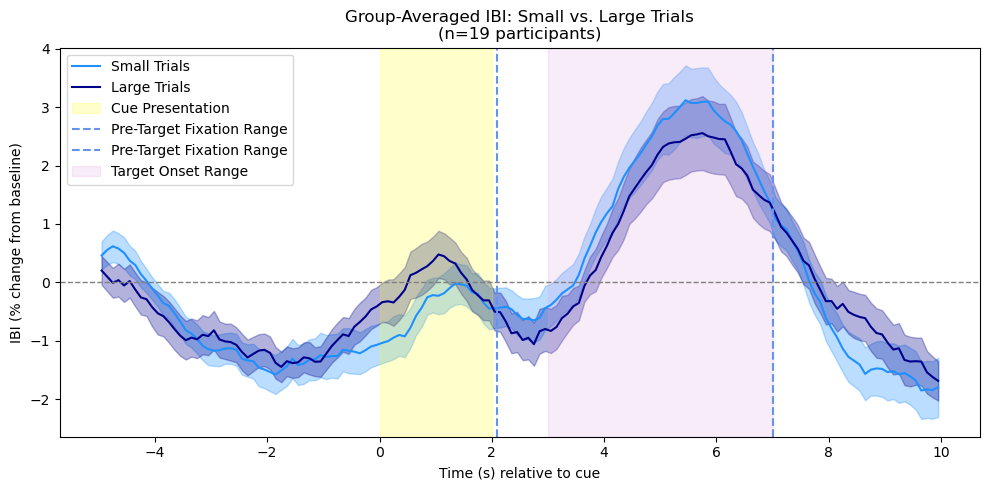

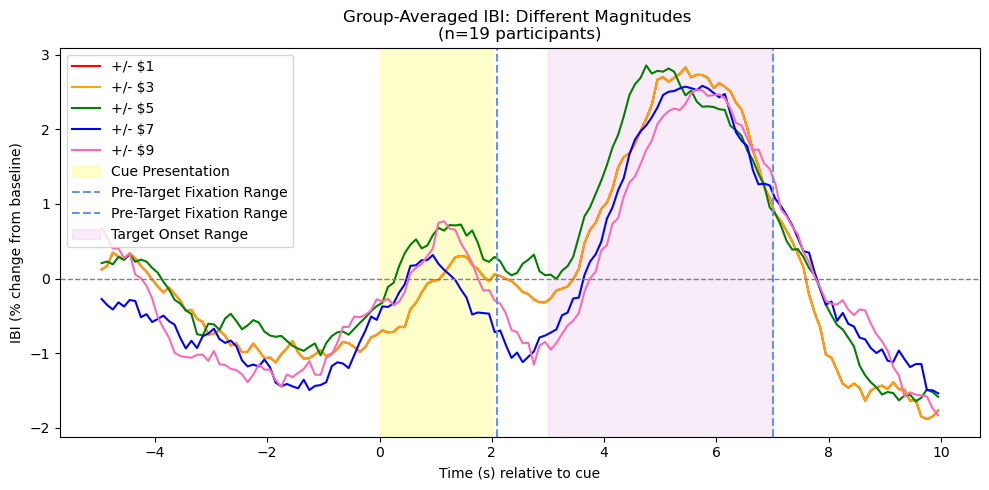

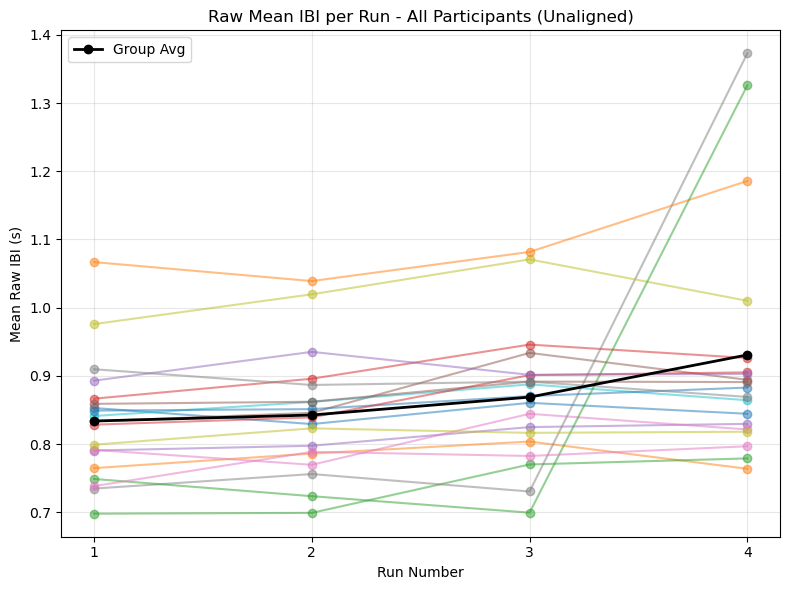

In [37]:
participants = ["4111", "4112", "4113", "4114", "4115", "4117", "4120", "4125", "4127", "4121", "4142", "4139", "4148", "4145", "4152", "4149", "4103",
               "4156", "4160"]  

base_path="/restricted/projectnb/cd-lab/yesh/physio/MID"
participant_path = f"{base_path}/Physio_outputs/p{participants}"
peak_base=participant_path
base_dir = "/restricted/projectnb/cd-lab/yesh/physio/MID/DICOMS"
csv_base = "/restricted/projectnb/cd-lab/yesh/physio/MID/CSVs"


all_participant_runs, group_ibi_matrix, bins, participant_means, all_ibi_runs_by_participant, all_peak_times_by_participant, cleaned_dict = run_group_pipeline(participants, base_dir)

is_mean_ibi_consistent_across_runs(all_peak_times_by_participant, participants)

ibi_long=convert_runs_to_long(all_ibi_runs_by_participant, participants, cleaned_dict)
ibi_long.to_csv("group_IBI_trials_cue.csv", index=False) 

## Converting physio data to long format for IBI modeling 
* each row is one time bin -- there are 150 time bins per trials

In [36]:
#Convert physio data to long form for IBI modeling == each row is one time bin (150 time bins per trial)
def convert_runs_to_long(all_ibi_runs_by_participant, participants, cleaned_dict):
    all_subject_ibis_long = []  
    
    for pid, runs in zip(participants, all_ibi_runs_by_participant):
        cleaned = cleaned_dict[pid]
        participant_baseline = participant_means.get(pid, np.nan)

        for run_idx, run_matrix in enumerate(runs):
            n_trials, n_bins = run_matrix.shape
            df = pd.DataFrame(run_matrix, columns=[f"bin_{i}" for i in range(n_bins)])
            df["subject"] = pid
            df["RunNumber"] = run_idx + 1
            
            meta=cleaned[cleaned["RunNumber"]==run_idx+1]
            df["Trial"] = meta["Trial"].values

            df = df.merge(
                cleaned[['RunNumber','Trial','CueType','FixationDuration','EarlyHit']], 
                on=['RunNumber','Trial'],
                how='left'
            )

            df["baseline_IBI"] = participant_baseline

            # new variables
            df["PotentialGain"] = (df["CueType"] > 5).astype(int)

            magnitude_map = {
                1: 1, 6: 1,
                2: 3, 7: 3,
                3: 5, 8: 5,
                4: 7, 9: 7,
                5: 9, 10: 9
            }
            df["Magnitude"] = df["CueType"].map(magnitude_map)

            # time-since-fixation bins
            bin_centers = np.arange(n_bins) * 0.1
            fixation_onset= 2.0

            #create matrix of bin centers for all trials 
            bin_matrix=np.tile(bin_centers, (n_trials,1))

            #time since fixation onset
            time_since_fix_matrix=bin_matrix-fixation_onset
            time_since_fix_matrix[time_since_fix_matrix<0]=0

            #after fixation end = NaN
            fixation_end_matrix=fixation_onset + df["FixationDuration"].values[:,None]
            time_since_fix_matrix[bin_matrix>fixation_end_matrix]=np.nan

            # mask entire trial if EarlyHit is NA
            early_hit_mask = df["EarlyHit"].isna().values[:, None]  # shape (n_trials, 1)
            time_since_fix_matrix = np.where(early_hit_mask, np.nan, time_since_fix_matrix)


            #convert to data frame
            time_since_fix_df=pd.DataFrame(
                time_since_fix_matrix,
                columns=[f"time_since_fix_bin_{i}" for i in range(n_bins)]
            )
            
            df = pd.concat([df, time_since_fix_df], axis=1)
            all_subject_ibis_long.append(df)

    ibi_long = pd.concat(all_subject_ibis_long, ignore_index=True)
    return ibi_long


## Running a paired t-test between groups

In [38]:
def stats_2s(mean_gain_list_norm, mean_loss_list_norm,
             mean_large_list_norm, mean_small_list_norm,
             bin_centers):

    import numpy as np
    from scipy.stats import ttest_rel

    window = (bin_centers >= 0) & (bin_centers <= 2)
    window_ant = (bin_centers >= 2) & (bin_centers <= 3)

    # Convert lists of participant timecourses → arrays
    gain_arr = np.vstack(mean_gain_list_norm)
    loss_arr = np.vstack(mean_loss_list_norm)
    large_arr = np.vstack(mean_large_list_norm)
    small_arr = np.vstack(mean_small_list_norm)

    # Average within 0–2s for each participant
    gain_vals = np.nanmean(gain_arr[:, window], axis=1)
    loss_vals = np.nanmean(loss_arr[:, window], axis=1)
    large_vals = np.nanmean(large_arr[:, window], axis=1)
    small_vals = np.nanmean(small_arr[:, window], axis=1)

    
    # Average within 2–3s for each participant
    gain_vals_ant = np.nanmean(gain_arr[:, window_ant], axis=1)
    loss_vals_ant = np.nanmean(loss_arr[:, window_ant], axis=1)
    large_vals_ant = np.nanmean(large_arr[:, window_ant], axis=1)
    small_vals_ant = np.nanmean(small_arr[:, window_ant], axis=1)


    # Paired t-tests
    t_gain_loss, p_gain_loss = ttest_rel(gain_vals, loss_vals, nan_policy='omit')
    t_large_small, p_large_small = ttest_rel(large_vals, small_vals, nan_policy='omit')

    # Paired t-tests
    t_gain_loss_ant, p_gain_loss_ant = ttest_rel(gain_vals_ant, loss_vals_ant, nan_policy='omit')
    t_large_small_ant, p_large_small_ant = ttest_rel(large_vals_ant, small_vals_ant, nan_policy='omit')
    

    print("\n===== 0–2s Paired t-tests =====")
    print(f"Gain vs Loss:   t = {t_gain_loss:.3f}, p = {p_gain_loss:.4f}")
    print(f"Large vs Small: t = {t_large_small:.3f}, p = {p_large_small:.4f}")
    print("================================\n")

    print("\n===== 2–3s Paired t-tests =====")
    print(f"Gain vs Loss:   t = {t_gain_loss_ant:.3f}, p = {p_gain_loss_ant:.4f}")
    print(f"Large vs Small: t = {t_large_small_ant:.3f}, p = {p_large_small_ant:.4f}")
    print("================================\n")


    # Return results in case you want to save/log them
    return {
        "gain_loss": (t_gain_loss, p_gain_loss),
        "large_small": (t_large_small, p_large_small),
        "gain_loss_ant" : (t_gain_loss_ant, p_gain_loss_ant),
        "large_small_ant": (t_large_small_ant, p_large_small_ant)
        
    }


In [42]:
def print_ttest_result(label, ttest_tuple, n=None):
    """
    Pretty-print a t-test result.

    Parameters
    ----------
    label : str
        Description of the comparison (e.g., "Gain vs Loss – Anticipatory IBI")
    ttest_tuple : tuple
        (t_statistic, p_value)
    n : int, optional
        Sample size (number of participants) for df display
    """
    t, p = ttest_tuple

    if n is not None:
        df = n - 1
        print(f"{label}: t({df}) = {t:.3f}, p = {p:.3g}")
    else:
        print(f"{label}: t = {t:.3f}, p = {p:.3g}")


## Group Analysis Pipeline -- Condition Specific Baseline Correction

For each participant, raw PPG peak times are first aligned in time to cue onset to construct trial-level, event-related IBI trajectories. In addition to temporal alignment, the pipeline applies a participant- and condition-specific baseline correction using a pre-cue window (–2 to 0 s), ensuring that gain and loss (and small and large magnitude) timecourses enter the anticipatory period from a common baseline level.

At the participant level, the pipeline:
* Loads cleaned behavioral trial data and raw peak time files for each run.
* Generates aligned IBI timecourses around cue onset using a single-participant processing pipeline.
* Extracts gain vs loss and large vs. small magnitude trial subsets.
* Performs participant-specific baseline correction using a pre-cue window (–2 to 0 s) and normalizes all timecourses to percent change from baseline.
* Computes condition-specific mean IBI timecourses for each participant.
* Derives participant-level difference waves for valence (loss – gain) and magnitude (large – small) contrasts.

 **At the group level, the pipeline:** 
*   Aggregates all participant timecourses into a stacked group IBI matrix.
* Generates diagnostic and results plots including:
* Overall IBI timecourse shape around cue onset,
* Gain vs loss comparisons,
* Small vs large magnitude comparisons,
* Group-level difference waves for valence and magnitude.
* Performs paired-sample statistical tests comparing gain vs. loss and large vs. small conditions across participants.


In [43]:
def run_group_pipeline_corrected(participants, base_dir, plot_all=True):
    """
    Runs group level IBI analysis pipeline:
    - Loads multiple participants data and peak times
    - Calculates per-run baselines and normalized metrics 
    - Aggregates group data for plotting and group level analyses
    - Returns raw peak times for optional unaligned IBI analysis
    """
    import traceback
    import os
    import numpy as np
    
    # initialize storage for group results 
    all_ibi_runs_by_participant = []  # list of per-participant lists of runs (each run is a 2d array)
    all_participant_runs = []  # flattened list of all run data for all participants
    all_peak_times_by_participant = []  #raw peak timestamps for each participant
    cleaned_dict={}

    mean_loss_list = []
    mean_gain_list = []
    mean_loss_list_norm = []
    mean_gain_list_norm = []

    mean_small_list = []
    mean_large_list = []
    mean_small_list_norm = []
    mean_large_list_norm = []

    mean_mag1_list=[]
    mean_mag3_list=[]
    mean_mag5_list=[]
    mean_mag7_list=[]
    mean_mag9_list=[]

    mean_ibi_mag1_list_norm=[]
    mean_ibi_mag3_list_norm=[]
    mean_ibi_mag5_list_norm=[]
    mean_ibi_mag7_list_norm=[]
    mean_ibi_mag9_list_norm=[]

    diff_large_small_list=[]
    diff_loss_gain_list=[]
    
    
    bin_centers = None
    participant_means = {}  # store person-specific baselines
    gain_means= {}
    loss_means={}

    # iterate over all participants 
    for pid in participants:
        try:
            # Define file paths 
            participant_path = f"{base_path}/Physio_outputs"
            peak_base = participant_path
            print(f"\n--- Starting {pid} ---")
            
            csv_path = os.path.join(csv_base, f"p{pid}_data.csv")
            peak_times_dir = os.path.join(peak_base, f"p{pid}")

            print(f"CSV path: {csv_path}")
            print(f"Peak times dir: {peak_times_dir}")
            
            # Check that csv and peak files exist 
            if not os.path.exists(csv_path):
                print(f"❌ CSV file not found for {pid}")
                continue
            if not os.path.isdir(peak_times_dir):
                print(f"❌ Peak directory not found for {pid}")
                continue
            
            # ---  load raw peak times (unaligned) ---
            peaks_for_participant = load_peak_times(peak_times_dir, n_runs=4)
            all_peak_times_by_participant.append(peaks_for_participant)
            
            # Run single participant pipeline to get aligned IBIs
            all_ibi_runs, bin_centers = run_pipeline_single(
                csv_path=csv_path,
                peak_times_dir=peak_times_dir,
                plot_run=None,
                plot_n_trials=0,
                plot_group_average=False,
                plot_task_average=False,
                plot_gainloss=False,
                plot_smalllarge=False,
                plot_magnitudes_flag=False
            )
            
            all_ibi_runs_by_participant.append(all_ibi_runs)

            # Stack all runs for this participant into a 2d array
            participant_ibi = np.vstack(all_ibi_runs)

            if participant_ibi.size == 0:
                print(f"No IBI data for participant {pid}")
                continue

        
            # Compute person-specific baseline
            #participant_mean_ibi = np.nanmean(participant_ibi)
            #participant_means[pid] = participant_mean_ibi

            # Load cleaned csv - early hit trials removed  
            cleaned = load_data(csv_path)
            cleaned_dict[pid]=cleaned

            ## --- Trial type averages and normalizations ----
            # Gain/Loss
            mean_ibi_loss, mean_ibi_gain, loss_trials, gain_trials = gainorloss(cleaned, participant_ibi)
            

            #participant x condition specific baseline to baseline correct 
            baseline_window=(bin_centers >= -2) & (bin_centers <=-0)

            all_trials=np.vstack([gain_trials, loss_trials])
            participant_baseline=np.nanmean(all_trials[:, baseline_window])
            
            #Gain/Loss Corrected
            #establishing the baseline window
            gain_baseline=np.nanmean(gain_trials[:, baseline_window])
            loss_baseline=np.nanmean(loss_trials[:, baseline_window])

            #baseline correcting the trials
            gain_corrected_tc=gain_trials-gain_baseline
            loss_corrected_tc=loss_trials-loss_baseline

            #getting the mean timecourse of the corrected trials 
            mean_ibi_gain_corrected=np.nanmean(gain_corrected_tc, axis=0)
            mean_ibi_loss_corrected=np.nanmean(loss_corrected_tc, axis=0)

            #normalizing the time course 
            mean_ibi_gain_corrected_norm=(mean_ibi_gain_corrected/ participant_baseline) * 100
            mean_ibi_loss_corrected_norm=(mean_ibi_loss_corrected / participant_baseline) * 100
            

            #Store 
            mean_loss_list.append(mean_ibi_loss_corrected)
            mean_gain_list.append(mean_ibi_gain_corrected)
            mean_loss_list_norm.append(mean_ibi_loss_corrected_norm)
            mean_gain_list_norm.append(mean_ibi_gain_corrected_norm)

            gain_means[pid]=gain_baseline
            loss_means[pid]=loss_baseline
            participant_means[pid]=participant_baseline

            #Big/Small Corrected
            mean_ibi_large, mean_ibi_small, large_trials, small_trials = smallorlarge(cleaned, participant_ibi)
            #establishing the baseline window
            large_baseline=np.nanmean(large_trials[:, baseline_window])
            small_baseline=np.nanmean(small_trials[:,baseline_window])
            
            #baseline correcting the trials
            large_corrected_tc=large_trials-large_baseline
            small_corrected_tc=small_trials-small_baseline

            #mean time course of corrected trials 
            mean_ibi_large_corrected=np.nanmean(large_corrected_tc, axis=0)
            mean_ibi_small_corrected=np.nanmean(small_corrected_tc, axis=0)

            #normalizing the tc to be in % change
            mean_ibi_large_corrected_norm=(mean_ibi_large_corrected / participant_baseline) *100
            mean_ibi_small_corrected_norm=(mean_ibi_small_corrected / participant_baseline) * 100

            #Store
            mean_large_list.append(mean_ibi_large_corrected)
            mean_small_list.append(mean_ibi_small_corrected)
            mean_large_list_norm.append(mean_ibi_large_corrected_norm)
            mean_small_list_norm.append(mean_ibi_small_corrected_norm)

            #Difference waves
            #small vs large 
            diff_large_small=mean_ibi_large_corrected_norm - mean_ibi_small_corrected_norm
            diff_loss_gain=mean_ibi_loss_corrected_norm-mean_ibi_gain_corrected_norm

            diff_large_small_list.append(diff_large_small)
            diff_loss_gain_list.append(diff_loss_gain)

            all_participant_runs.append(participant_ibi)

        except Exception as e:
            print(f"Failed to process {pid}: {e}")
            traceback.print_exc()

    if not all_participant_runs:
        print("No participant data found — cannot stack arrays.")
        return None, None, None, None, None, None

    # Stack all participants' data vertically (all trials from all participants)
    group_ibi_matrix = np.vstack(all_participant_runs)

    if plot_all:
        #plot_4_runs_by_participant(all_ibi_runs_by_participant, bin_centers, participants, participant_means)
        is_consistent_across_runs(all_ibi_runs_by_participant, bin_centers, participant_means, participants)
        what_shape_cue_presentation(all_participant_runs, bin_centers, participants)
        is_difference_gain_vs_loss(mean_loss_list_norm, mean_gain_list_norm, bin_centers, participants)
        is_difference_small_vs_large(mean_large_list_norm, mean_small_list_norm, bin_centers, participants)
        plot_group_diff_waves(diff_large_small_list, diff_loss_gain_list, bin_centers, participants)
        #is_difference_between_magnitudes(mean_ibi_mag1_list_norm, mean_ibi_mag3_list_norm, mean_ibi_mag5_list_norm, mean_ibi_mag7_list_norm, mean_ibi_mag9_list_norm, bin_centers, participants)
    # --- Now returns peak times too ---

    tresults=stats_2s(mean_gain_list_norm, mean_loss_list_norm, mean_large_list_norm, mean_small_list_norm, bin_centers)

    results_corrected={
    "participants": participants, 
    "all_participant_runs": all_participant_runs,
    "group_ibi_matrix": group_ibi_matrix,
    "bin_centers": bin_centers,
    "participant_means": participant_means,
    "ibi_runs_by_participant": all_ibi_runs_by_participant,
    "peak_times_by_participant": all_peak_times_by_participant,
    "mean_loss": mean_loss_list_norm,
    "mean_gain": mean_gain_list_norm,
    "mean_large": mean_large_list_norm,
    "mean_small": mean_small_list_norm,
    "diff_size": diff_large_small_list,
    "diff_mag": diff_loss_gain_list,
    "tresults": tresults,
    "cleaned_dict": cleaned_dict,
    }
    return results_corrected



--- Starting 4111 ---
CSV path: /restricted/projectnb/cd-lab/yesh/physio/MID/CSVs/p4111_data.csv
Peak times dir: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4111
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4111/peakTimes_PPG_Siemens_col_r1.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4111/peakTimes_PPG_Siemens_col_r2.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4111/peakTimes_PPG_Siemens_col_r3.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4111/peakTimes_PPG_Siemens_col_r4.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4111/peakTimes_PPG_Siemens_col_r1.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4111/peakTimes_PPG_Siemens_col_r2.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4111/peakTimes_PPG_Siemens_col_r3.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_out

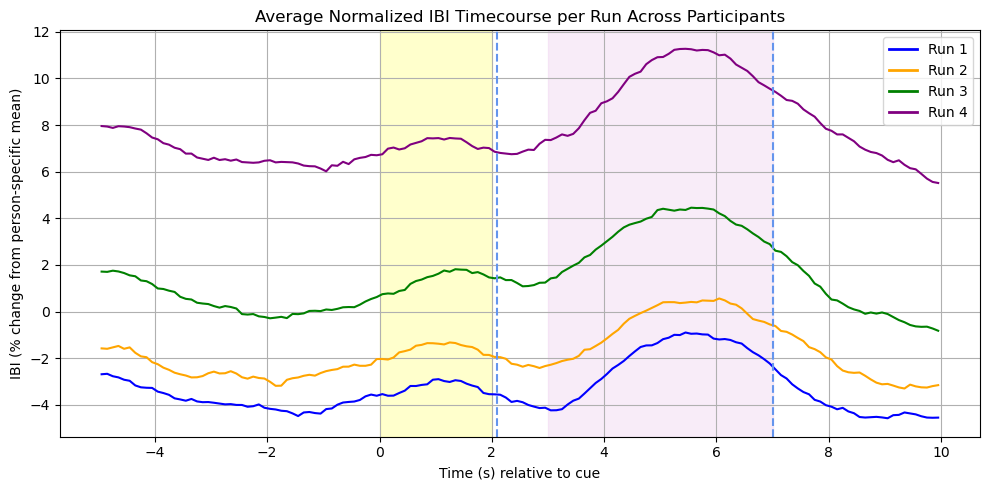

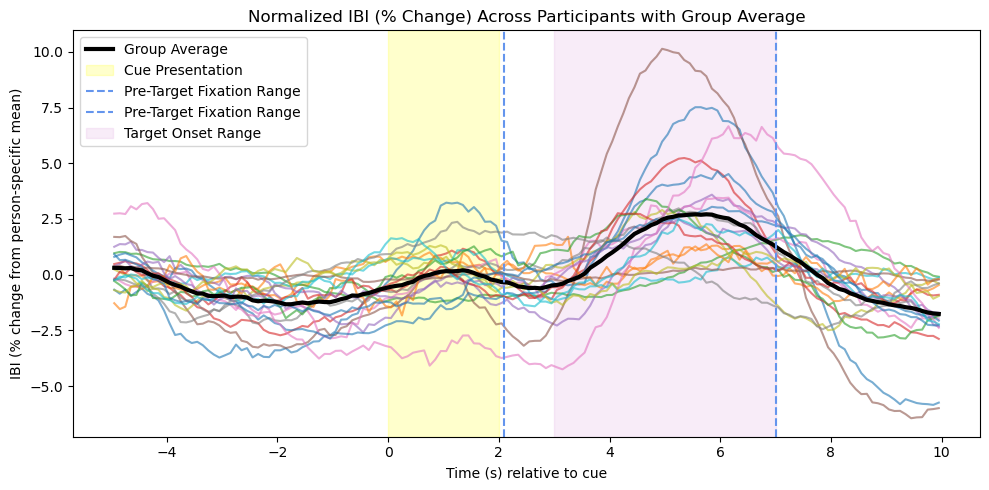

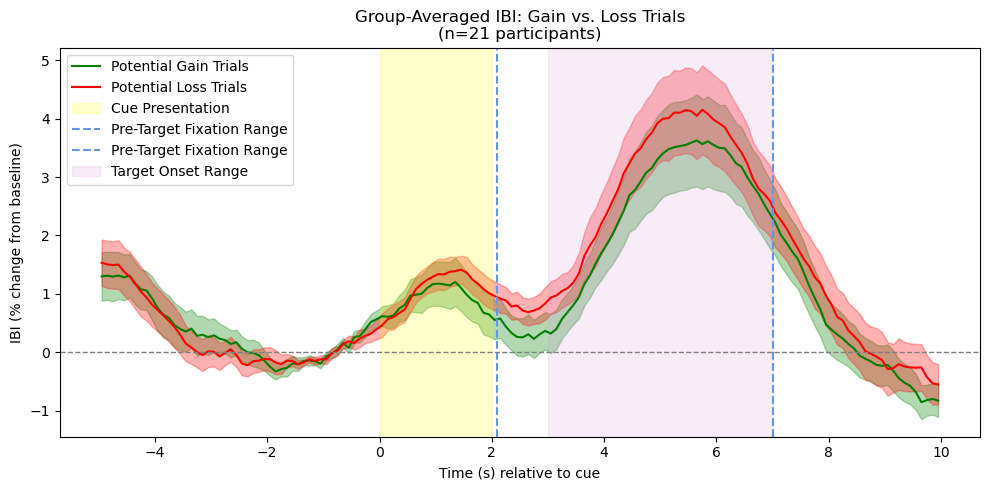

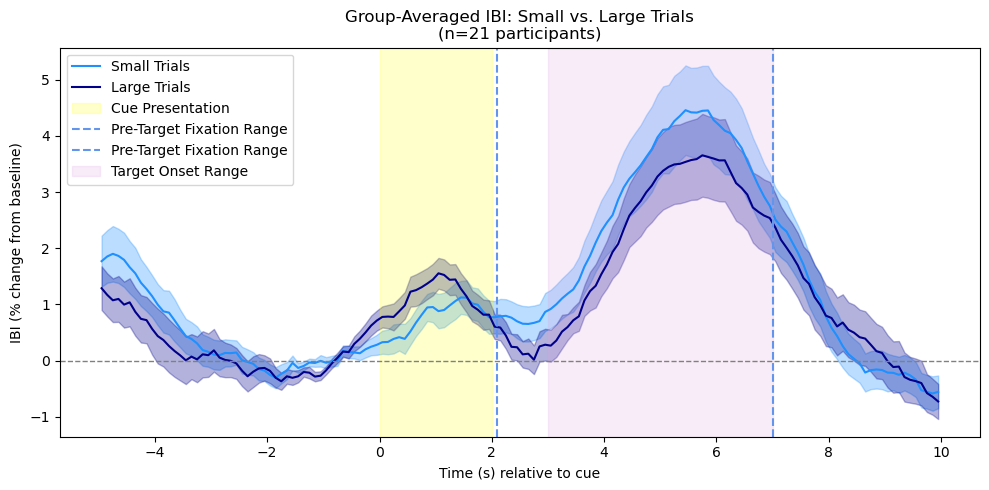

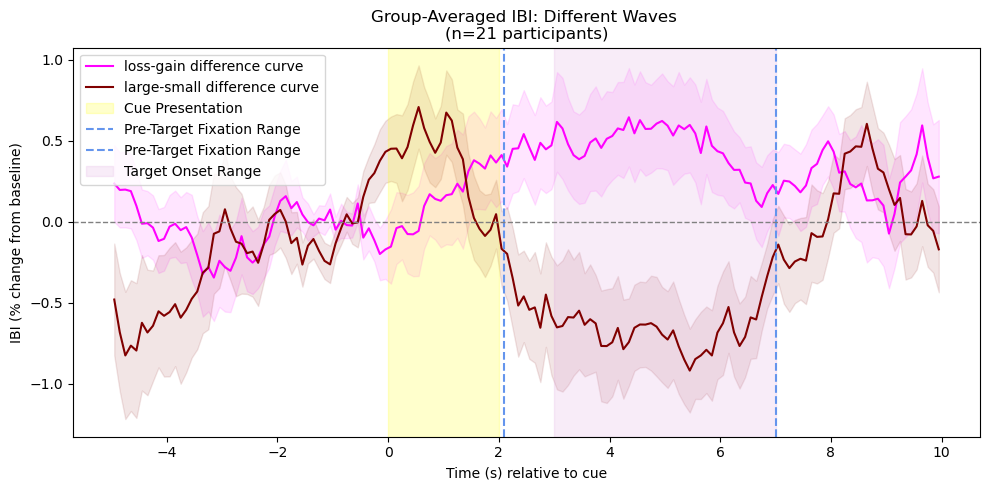


===== 0–2s Paired t-tests =====
Gain vs Loss:   t = -0.639, p = 0.5301
Large vs Small: t = 1.903, p = 0.0716


===== 2–3s Paired t-tests =====
Gain vs Loss:   t = -1.749, p = 0.0956
Large vs Small: t = -1.548, p = 0.1373



In [44]:
results_corrected = run_group_pipeline_corrected(participants, base_dir)


### Saving out the IBI data in long form for modeling in R
150 time bins per trial

In [45]:
ibi_long=convert_runs_to_long(all_ibi_runs_by_participant, participants, cleaned_dict)
ibi_long.to_csv("group_IBI_trials_cue.csv", index=False) 

# **Results**

## How does IBI dynamically change around cue presentation in the MID task?
* anticipatory phase? --- anticipatory phase = cardiac slowing -- there is slight cardiac slowing after cue presentation 

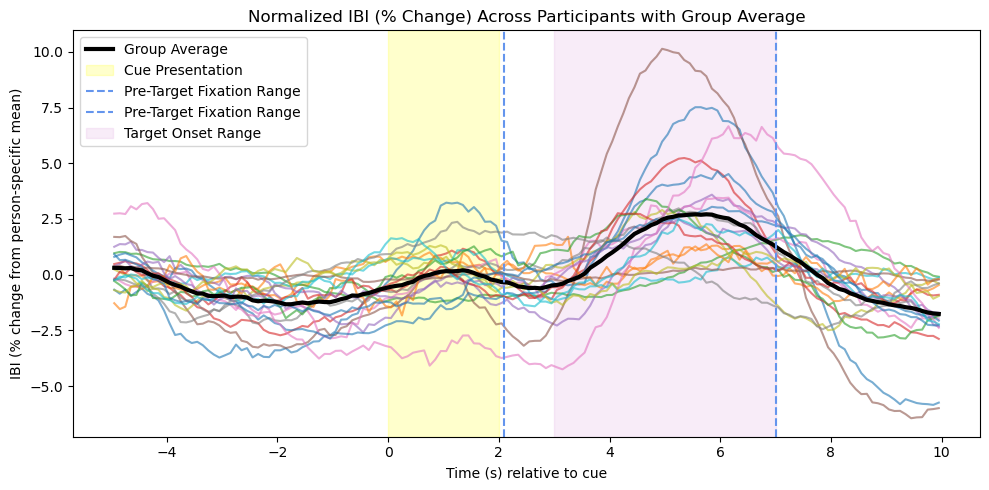

In [46]:
def plot_shape_from_results(results):
    what_shape_cue_presentation(
        results["all_participant_runs"],
        results["bin_centers"],
        participants
    )

plot_shape_from_results(results_corrected)


## Is the IBI timecourse consistent across runs?
* The shape of the timecourse remained consistent across runs
* IBI per trial tended to be greater as the task continued on -- this makes sense as the participants started to feel more settled in the scanner and less nervous 

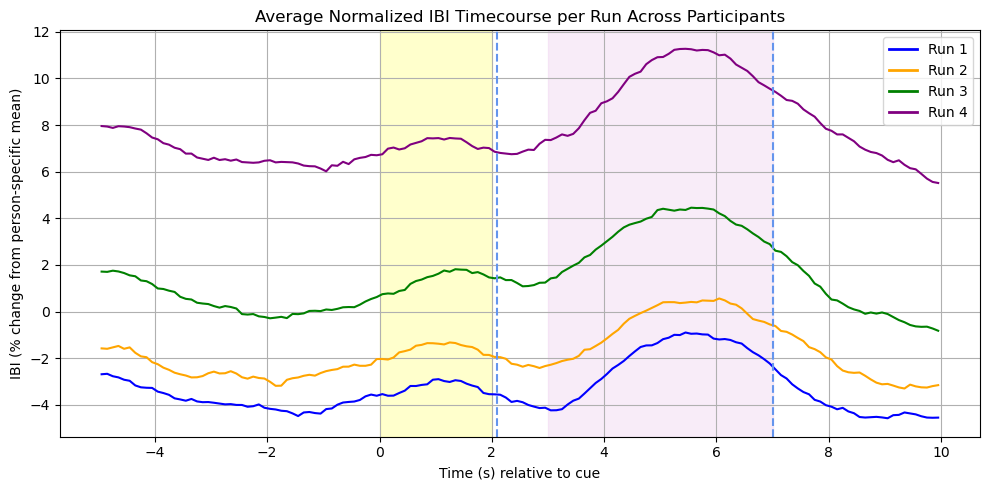

In [47]:
def plot_shape_across_runs(results):
    is_consistent_across_runs(
        results["ibi_runs_by_participant"],
        results["bin_centers"],
        results["participant_means"],
        participants
    )

plot_shape_across_runs(results_corrected)
        

## How different is average IBI different across runs?

In [48]:
rows = []
for pid, run_array in zip(participants, all_ibi_runs_by_participant):
    for run_idx, run_values in enumerate(run_array):  # loop through runs
        mean_ibi = np.nanmean(run_values)  
        rows.append({"participant": pid, "run": run_idx + 1, "mean_IBI": mean_ibi})

ibi_df = pd.DataFrame(rows)

In [49]:
group_avg_df = ibi_df.groupby("run")["mean_IBI"].mean().reset_index()
group_avg_df.rename(columns={"mean_IBI": "group_mean_IBI"}, inplace=True)


In [50]:
print(group_avg_df)

   run  group_mean_IBI
0    1        0.832557
1    2        0.845433
2    3        0.872703
3    4        0.929415


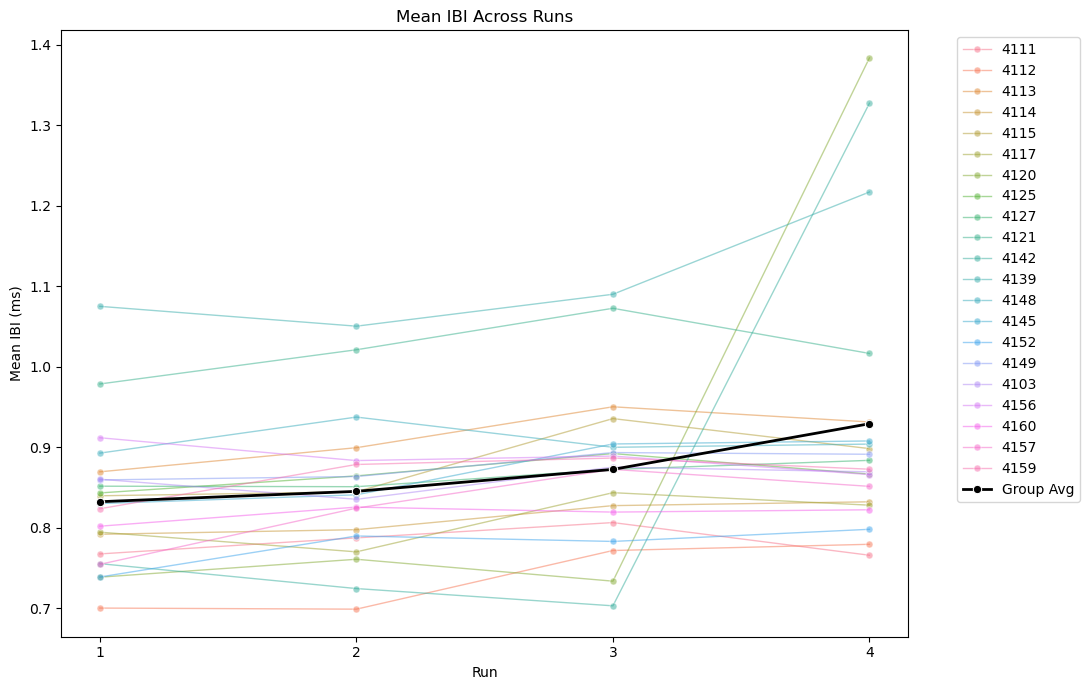

In [51]:
plt.figure(figsize=(11, 7))

# Line + dots for each participant
sns.lineplot(
    data=ibi_df,
    x="run",
    y="mean_IBI",
    hue="participant",
    alpha=0.5,
    linewidth=1,
    marker="o",     # <- adds a dot at each x value
    markersize=5
)

# Group average line with dots
sns.lineplot(
    data=group_avg_df,
    x="run",
    y="group_mean_IBI",
    color="black",
    linewidth=2,
    marker="o",     
    markersize=6,
    label="Group Avg"
)

# Set title and axis
plt.title("Mean IBI Across Runs")
plt.xlabel("Run")
plt.ylabel("Mean IBI (ms)")
plt.xticks([1, 2, 3, 4])  # <- only ticks at run numbers
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Do participants' IBI timecourses differ between potential gain and loss trials?
* The IBI timecourse (averaged across participants) is consistent when presented with potential gain or potential loss cue types

The t-test tests if there is statistically significant difference between the mean IBI in the two different conditions. The t-tests suggest that there is no statistically significant in the mean IBI between gain and loss trials in the 2s cue presentation window, nor in the 1s of guaranteed pre-target fixation time in each trial

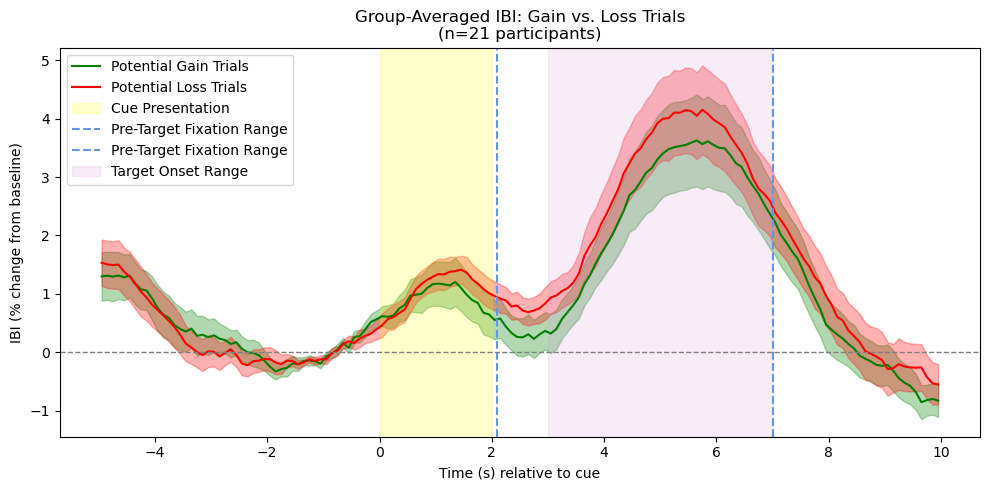

In [52]:
def plot_gain_and_loss(results):
    is_difference_gain_vs_loss(
        results["mean_loss"],
        results["mean_gain"],
        results["bin_centers"],
        participants
    )

plot_gain_and_loss(results_corrected)

In [53]:
tresults = results_corrected["tresults"]

print_ttest_result(
    "Gain vs Loss IBI During Cue Presentation",
    tresults["gain_loss"],
    n=len(results_corrected["mean_gain"])
)


print_ttest_result(
    "Gain vs Loss IBI During the First Second of the Fixation Period",
    tresults["gain_loss_ant"],
    n=len(results_corrected["mean_gain"])
)

Gain vs Loss IBI During Cue Presentation: t(20) = -0.639, p = 0.53
Gain vs Loss IBI During the First Second of the Fixation Period: t(20) = -1.749, p = 0.0956


## Do participants' IBI timecourses differ between small and large trial types? 

The plots suggest there is not a big difference in the IBI changes during cue presentation between the small trials (magnitude 1 dollar and 3 dollar) vs the large trials (magnitude7 dollars and 9 dollars). It is worth noting that the IBI timecourse more steeply declines with the large trials during the 1s anticipation period. 

The paired t-test suggests that there are differences between the two groups but not yet at a statistically significant level. 

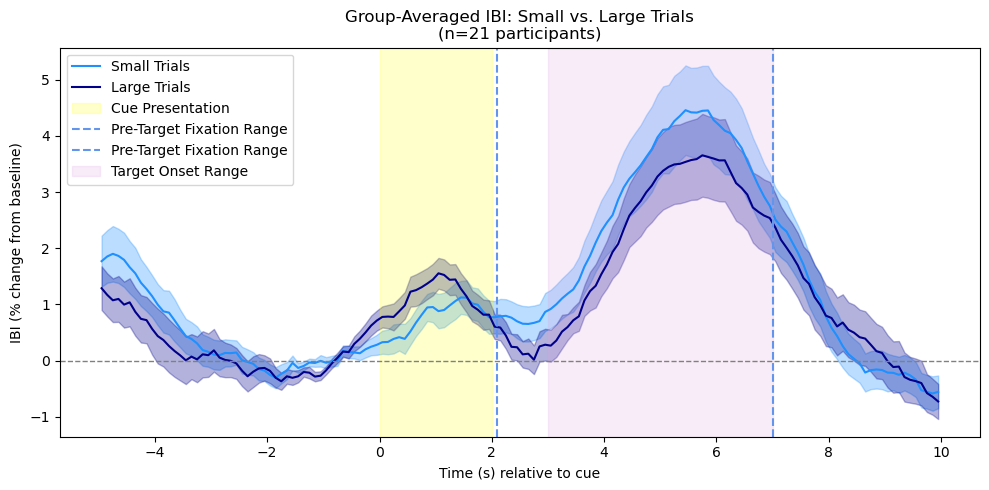

In [54]:
def plot_big_and_small(results):
    is_difference_small_vs_large(
        results["mean_large"],
        results["mean_small"],
        results["bin_centers"],
        participants
    )
plot_big_and_small(results_corrected)
        

In [55]:
tresults = results_corrected["tresults"]

print_ttest_result(
    "Gain vs Loss IBI During Cue Presentation",
    tresults["large_small"],
    n=len(results_corrected["mean_gain"])
)


print_ttest_result(
    "Gain vs Loss IBI During the First Second of the Fixation Period",
    tresults["large_small_ant"],
    n=len(results_corrected["mean_gain"])
)

Gain vs Loss IBI During Cue Presentation: t(20) = 1.903, p = 0.0716
Gain vs Loss IBI During the First Second of the Fixation Period: t(20) = -1.548, p = 0.137


## Do difference waves suggest any meaningful effects of cue valence or magnitude on the participant-averaged IBI timecourse?
* All differences seem to be within 1% of the baseline IBI, which suggests that differences in cue valence and magnitude do not meaningfully modulate participants' heart rates.

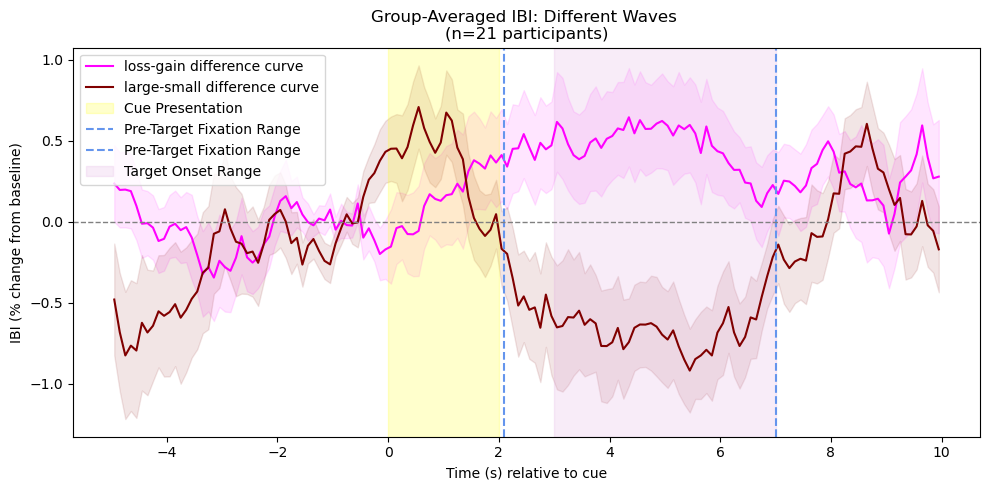

In [56]:
def plot_diff_waves(results):
    plot_group_diff_waves(
        results["diff_size"],
        results["diff_mag"],
        results["bin_centers"],
        participants
    )

plot_diff_waves(results_corrected)